# Topic Detection on My Google Searches

Some parts are adapted from https://www.analyticsvidhya.com/blog/2016/08/beginners-guide-to-topic-modeling-in-python/ and sklearn examples


In [496]:
import numpy as np
import pandas as pd
from tqdm import tqdm

from sklearn.decomposition import NMF, LatentDirichletAllocation

%load_ext snakeviz

import matplotlib.pyplot as plt
import seaborn as sns

from bokeh.io import output_file, show, output_notebook, curdoc, push_notebook
from bokeh.plotting import figure
from bokeh.models import ColumnDataSource, HoverTool, TapTool, OpenURL, Title, WheelZoomTool
from bokeh.layouts import row,column, widgetbox
from bokeh.models import FactorRange
from bokeh.models.widgets import Select
from bokeh.embed import components

output_notebook()

The snakeviz extension is already loaded. To reload it, use:
  %reload_ext snakeviz


Loading BokehJS ...

In [2]:
from google_topic_utilities import *

## Load, clean and prepare corpus data

In [330]:
# Load data
indir = "Recherches/NLP/"
corpus_dict = load_corpus(indir)

# Process data
doc_clean = clean_text_data(corpus_dict)

# Create Document-Term Dataframe

tf_thresh = 10
tfidf_thresh = 0

doc_term_df = make_doc_term_df(doc_clean,'tfidf', tf_thresh, tfidf_thresh)
print "{} words from {} queries are included in the analysis".format(doc_term_df.shape[1],doc_term_df.shape[0])


10400 words from 3545 queries are included in the analysis


## Apply Topic Detection Algorithm

In [331]:
# Set Params
no_topics = 20
top_words = 10

# Run NMF
nmf = NMF(n_components=no_topics, random_state=42)
nmf.fit_transform(doc_term_df.values)

# Get all related matrices
V_df, W_df, H_df = get_NMF_df(doc_term_df,nmf)

## Display results

### As Wordclouds

Topic #0: album music new video record song track american single born
Topic #1: piece one scan manga vostfr lecture torrent ligne vf hd
Topic #2: file function data matlab value using array line folder command
Topic #3: ball dragon kai episode étoiles gt saga goku épisodes animation
Topic #4: diffusion tensor imaging brain dti rat mri fa magnetic data
Topic #5: bruxelles ulb cours site service article météo programme belgique ligne
Topic #6: sleep polyphasic schedule sleeping everyman biphasic nap hour uberman day
Topic #7: streaming korra episode avatar film saison legend vostfr vf légende
Topic #8: webster instrumentation bioinstrumentation medical manual solution book pdf design john
Topic #9: timer countdown alarm minute online time min use stopwatch clock
Topic #10: server exorcist ao kyoto episode proxy java demon reverse summary
Topic #11: etape sauce poulet beurre mélanger farine recette mug ajouter microondes
Topic #12: game throne subtitle ro pt season fr episode nba drinkin

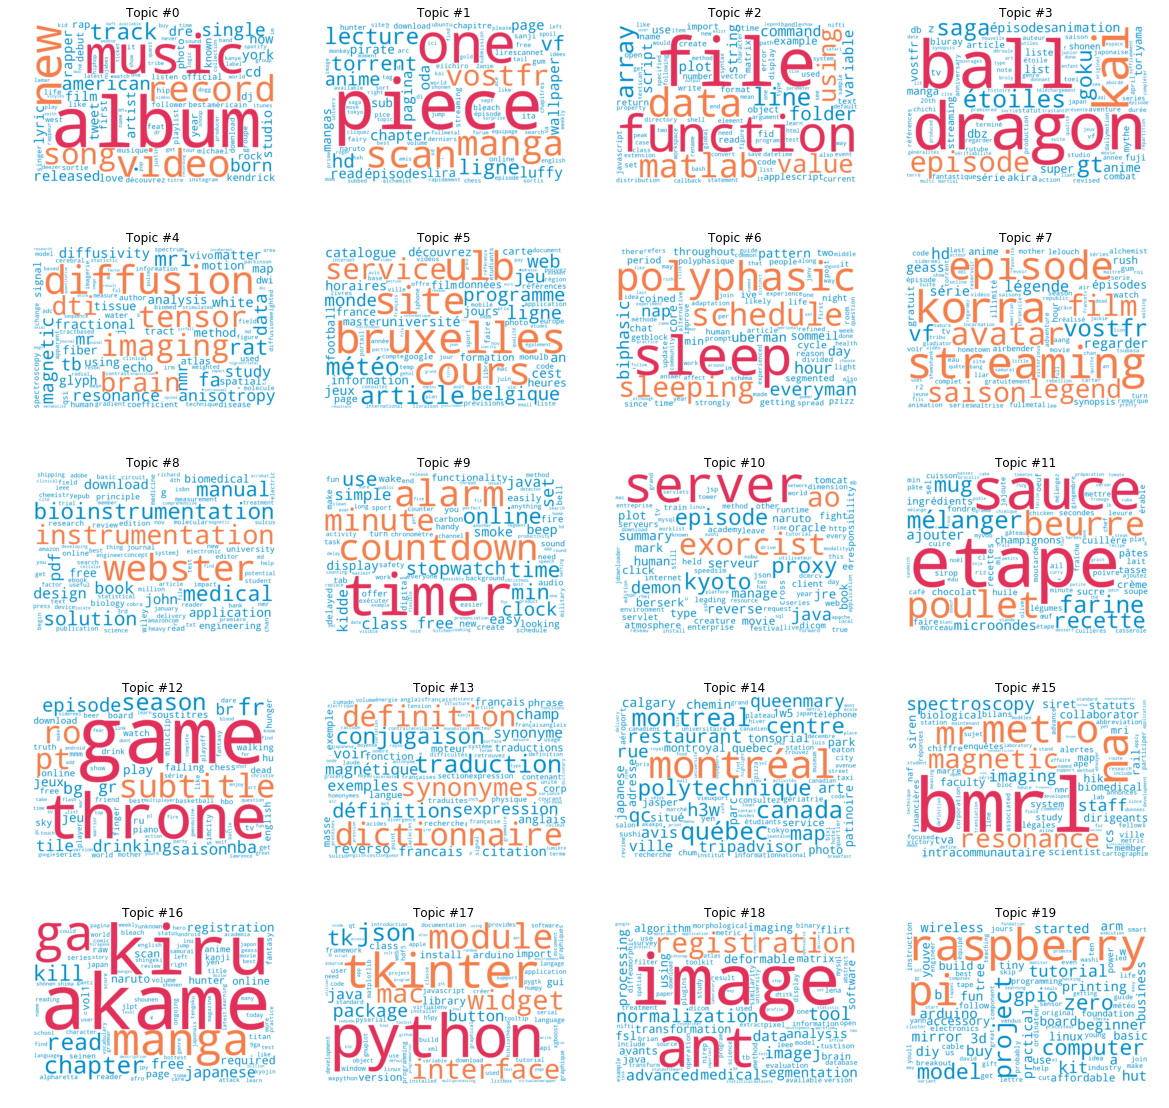

In [332]:
# List
display_topics(nmf, doc_term_df.columns.tolist(), top_words)

# Word clouds
word_cloud_words = 100
dims = (1200,800) # Attention modif values in color_func
topics_wordcloud(nmf, doc_term_df.columns.tolist(), word_cloud_words, dims)


### As an interactive display

#### Composition of topics

In [497]:
colors =["#F47D4A", "#E1315B", '#808080']
base_url = ''

topic_names = ['Music', 'Manga - One Piece', 'Matlab - Coding', 'Dragon Ball', 'Diffusion Tensor Imaging',
              'Divers (ULB, Belgique)', 'Polyphasic Sleep','Streaming','Biomedical','Timer','Mix','Cooking',
              'Games - Game of Thrones','Vocabulary','Montreal','-','Manga','Python - Coding','Image Registration',
              'Raspberry Pi'] 
topics_lut = {'Topic #%d' % topic_names.index(name) : name for name in topic_names}

topics_2d = format_topic_for_display(W_df,H_df, base_url, no_topics)

topics_2d.index = topics_2d.index.map(lambda t : topics_lut[t])

# Set source
allow_interactivity =[0,4,6,11, 13, 14,18]
no_interactivity = [i for i in range(no_topics) if i not in allow_interactivity]

topics_2d_interactive = topics_2d.iloc[allow_interactivity,:]
topics_2d_censored = topics_2d.iloc[no_interactivity,:]
topics_2d_censored.index = topics_2d_censored.index.map(lambda t : '-')
topics_2d_censored.url = topics_2d_censored.url.map(lambda t : None)

source_interactive = ColumnDataSource(topics_2d_interactive)
source_not_interactive = ColumnDataSource(topics_2d_censored)

# Configure tools
hover = HoverTool(tooltips=[
    ("Topic", "@index"),
    ("Searches", "@size")])
tap = TapTool(callback = OpenURL(url = '@url'))
zoom = WheelZoomTool()

# Configure figure
p1 = figure(width = 800, height =400,
            x_range = [-65,65],
            y_range = [-65,65], 
            tools = [hover,tap,zoom,'pan','reset'],
           active_scroll = zoom)
p1.title = Title(text="Topics visualized via dimensionality reduction", align="center") 

p1.axis.visible = False
p1.grid.visible = False

p1.toolbar_location = 'below'

# Interactive circles
p1.circle(x='PC1',y='PC2', size = 'viz_size',
            source = source_interactive,
           fill_color = colors[0], 
            line_color = colors[0],
           fill_alpha = 0.5,
           hover_color = colors[0],
           selection_color = colors[0],
           nonselection_fill_color = colors[0],
           nonselection_fill_alpha = 0.3,
           nonselection_line_color = colors[0])
# Fixed circles
p1.circle(x='PC1',y='PC2', size = 'viz_size',
            source = source_not_interactive,
           fill_color = colors[2], 
            line_color = colors[2],
           fill_alpha = 0.5,
             line_alpha = 0.5)

p1.line(x=0, y=[-1000,1000],
       line_color = 'grey',
       line_alpha = 0.3)
p1.line(x=[-1000,1000], y=0,
       line_color = 'grey',
       line_alpha = 0.3)

# show(p1)


(2, 10400)
[ 0.16965199  0.0823076 ]


GlyphRenderer(id='23e97110-ce32-4900-8682-1a9c2cd023e6', ...)

Note : 
When reducing dimensionality we see that the first two PC explain only 16.9% and 8% of the variance. It comes that the transformation mainly allows to distinguish between topic #0 and #1. The others being bundled in the center.

What does this tell? 
Maybe more topics needed?


#### Topic Presence over time

In [335]:
indir = 'Recherches/'
search_data = load_search_jsons(indir)
search_topics_df = get_query_topic_df(doc_clean, search_data,doc_term_df, no_topics, nmf)
agg_by_month = format_topic_trend_for_display(search_topics_df)

100%|██████████| 3545/3545 [04:20<00:00, 13.63it/s]


In [8]:
# agg_by_month.to_csv('agg_by_month.csv', encoding='utf-8')

In [424]:

# Display topic
topic_nr = 4

trend_source = ColumnDataSource(agg_by_month[['x_pos','Topic #%d'% topic_nr,'Topic #%d_terms'% topic_nr]])
f_range =  [(str(t[0]),str(t[1])) for t in trend_source.data['index']]

# Configure tools
hover = HoverTool(tooltips = [('Searches','@{Topic #%d}'% topic_nr),
                             ('Examples','@{Topic #%d_terms}'% topic_nr)])

# Dont understand the * notation in FactorRange argument
p_trend = figure(width = 1200, height =400, x_range = FactorRange(*f_range), tools =[hover, 'pan'])
p_trend.title = Title(text="Topic presence over time", align="center") 

p_trend.yaxis.visible = False
p_trend.xgrid.visible = False

p_trend.vbar(x='x_pos',
            width=0.7, bottom=0,
            top='Topic #%d'% topic_nr, 
            color= "#008DCB",
            alpha = 0.5,
             hover_color = colors[0],
            source = trend_source)
# show(p_trend)

GlyphRenderer(id='eba2e926-f1be-4229-b2d2-91de8909e88e', ...)

In [417]:
# show(column(p1,p_trend))

In [94]:
def modify_html_v2(html, models,script_tag, bokeh_tag) :
    
    # Create bokeh html components
    script, divs = components(models)

    # Insert Components into HTML
    # Script
    html_bokeh = re.sub(script_tag,script,html, count = 1)
    # Divs
    for div in divs :
        html_bokeh = re.sub(bokeh_tag,div,html_bokeh, count = 1)

    return html_bokeh
        
    
def insert_bokeh_into_html_v2(html_file, models, script_tag = "{{bokeh_script}}", bokeh_tag = "{{bokeh}}"):
    """
        models : tuple of models to embed, must be in the order we want them to appear in the HTML
        html_file : html file to modify
        script_tag : tag that marks the place of the bokeh script in the HTML file. There can be only one of these in the HTML. Defaults to {{bokeh_script}}
        bokeh_tag : tag that marks the place of the bokeh plots in the HTML file. There can be muiltiple such tags in the document. Defaults to {{bokeh_script}}
    """
    # Load HTML file
    with open(html_file,'r') as f :
        html = f.read()
    html_bokeh = modify_html_v2(html.decode('utf8'), models,script_tag, bokeh_tag)
    
    html_file_out = re.sub('.html$','_bokeh_embed.html',html_file)
    with open(html_file_out,'w') as f :
        f.write(html_bokeh.encode('utf8'))

In [110]:
insert_bokeh_into_html_v2('GoogleAnalysis_article_dev.html',(p1, p_trend))

In [485]:
def apply_formating_rules(string, hl_rules, ll_rules) :
    out = string
    
    # High-level processing
    for tag in hl_rules.keys():
        pattern = '^'+tag+'.*'
        if re.search(pattern,string) :
            if tag == '[^{}#\s]': # special case of no tag. Must be interpreted as a simple paragraph
                txt = re.search(pattern,string).group()
                out = re.sub('\[...\]',txt,hl_rules.get(tag))

            else :
                s = re.search(pattern,string).group()
                txt = s.split(tag)[1]
                out = re.sub('\[...\]',txt,hl_rules.get(tag))
                
    # Low-level processing
    for tag in ll_rules.keys():
        if tag == '{{url}}' :
            # special url processing
            pattern = tag + '[^}]*}'
            matches = re.finditer(pattern,out)
            for match in matches :
                m = match.group()
                url_pattern = '}[^{}]*{'
                text_pattern = '{[^{}]*}$'
                url = re.search(url_pattern,m).group()[1:-1]
                txt = re.search(text_pattern,m).group()[1:-1]

                repl_txt = re.sub('\[...\]',url,ll_rules.get(tag), count =1)
                repl_txt = re.sub('\[...\]',txt,repl_txt, count =1)
                out = re.sub(pattern,repl_txt,out, count =1)

        else :
            # The modification ends at the first space
            pattern = tag+'{[^{}]*}'
            matches = re.finditer(pattern,out)
            for match in matches :
                m = match.group()
                txt = m[len(tag)+1 : -1]
                repl_txt = re.sub('\[...\]',txt,ll_rules.get(tag))
                out = re.sub(pattern, repl_txt,out, count =1)

    return out
            

def html_format(txt_file, html_template, html_out):
    # List all formating rules. dict keys are the pattern and values are the replacement
    # High-level rules are those that format at the paragraph level
    hl_rules = {'{{title}}' :'<h2 class="w3-wide">[...]</h2>',
            '{{subtitle}}' :'<h4 class="w3-opacity">[...]</h4>',
            '{{section}}' :'<h3 class="w3-justify">[...]</h3>',
             '{{caption}}':'<p class="w3-opacity w3-center"><i>[...]</i></p>',
            '{{p}}' :'<p class="w3-justify">[...]</p>',
            '[^{}#\s]' :'<p class="w3-justify">[...]</p>',
            '{{img}}':'<img src="[...]" class="w3-round" alt="[missing image]" width="800px">',
            '#' :''}
    # Low-level rules are the HTML modification that occur within a paragraph
    ll_rules = {'{{i}}' : '<i>[...]</i>',
               '{{b}}' : '<b>[...]</b>',
               '{{url}}' : '<a href="[...]">[...]</a>'}
    
    content_tag = '{{text_content}}'

    # Read text file and html template
    with open(txt_file, 'r') as f :
        text = f.read()
    with open(html_template, 'r') as f :
        html_template = f.read()
    
    text_split = text.split('\n')
    
    #     ##[...]eof : ignore everything that follows
    try :
        idx_ignore_rest = text_split.index('##')
        text_split= [line for line in text_split if (line!='' and text_split.index(line)< idx_ignore_rest)]
    except :
        text_split= [line for line in text_split if line]
    
    # Apply all rules
    text_split_formated = []
    for string in text_split :
        text_split_formated.append(apply_formating_rules(string, hl_rules, ll_rules)) 
    
    text_formated ='\n'.join(text_split_formated)

    # Insert into html
    html = re.sub(content_tag,text_formated,html_template)
    
    # Save html file
    with open(html_out, 'w') as f :
        f.write(html)


In [498]:
html_format('GoogleAnalysis_article.txt','html_template.html', 'article.html' )
insert_bokeh_into_html_v2('article.html',(p1, p_trend))